<a href="https://colab.research.google.com/github/orlcast/symbolic_deep_learning/blob/master/GNN_with_strong_inductive_biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GNN with strong inductive biases 

Orlando Castellano, Domenico Caudo, Claudio Chilin

[link al github del progetto](https://github.com/orlcast/symbolic_deep_learning)


Il nostro lavoro è stato di implementare e riadattare il modello proposto nella pubblicazione '[Discovering Symbolic Models from Deep Learning with Inductive Biases](https://arxiv.org/abs/2006.11287)'. 

L'obiettivo finale è quello di estrarre una rappresentazione simbolica dell’interazione tra coppie di particelle utilizzando una GNN con bias induttivi. 

Per realizzare il dataset vengono generate delle simulazioni di sistemi di particelle interagenti con potenziale selezionabile. Ogni evento viene salvato in forma di grafo in cui ogni nodo rappresenta una particella, con le sue proprietà come features. 

Questa GNN, attraverso un semplice MLP, calcola gli edge tra coppie di nodi, che contengono l’informazione sull’interazione,  esegue il Message Passing  aggregando gli edge in un messaggio complessivo e con un secondo MLP utilizza i precedenti output per allenarsi sul valore delle accelerazioni. 

Il bias induttivo consiste nel trattare gli edge/messaggi come se rappresentassero proprio le forze ed è quindi imposto tramite l'operazione di aggregation: una somma element wise dei messaggi tra un nodo e i suoi vicini, che rappresenta la somma delle forze agenti su di una particella.

Infine utilizziamo il pacchetto PySR per effettuare la regressione simbolica sulle singole interazioni calcolate dal primo MLP.

# Import e installazione dei pacchetti necessari

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from torch import nn
from torch.functional import F
from torch.optim import Adam

from tqdm import tqdm

from matplotlib import pyplot as plt


#librerie per la gestione del dataset 
from sklearn.model_selection import train_test_split

#per le eq diff
from scipy.integrate import odeint

In [ ]:
!pip install celluloid

version_nums = torch.__version__.split('.')

version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric

from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.data import Data, DataLoader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download da github dei file:

- simulation.py contiene il codice necessario per realizzare le simulazioni
- models.py contiene il codice dei modelli di GNN 


# Simulazione di un sistema di particelle

Generiamo $n_s$ simulazioni di un sistema di particelle che evolve nel tempo scegliendo il potenziale di interazione e salvando ad ogni istante delle features per ogni particella (e.g. posizione, velocità, carica elettrica, massa) insieme alle singole componenti delle accelerazioni.

Ogni fotografia del sistema ad un certo istante di tempo verrà trattata dalla rete come un grafo completamente connesso in cui:

- A ciascuna particella è associato un nodo del grafo, ciascuno con $n_f$ features;

- I valori dell'accelerazione di ogni particella sono utilizzati come label per allenare la rete.

In [ ]:
!wget https://raw.githubusercontent.com/orlcast/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/orlcast/symbolic_deep_learning/master/simulate.py -O simulate.py

#librerie per il modello e le simulazioni 
import models
from models import OGN, get_edge_index 
import simulate
from simulate import SimulationDataset, make_transparent_color

--2022-07-12 13:55:52--  https://raw.githubusercontent.com/orlcast/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7100 (6.9K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   6.93K  --.-KB/s    in 0s      

2022-07-12 13:55:52 (43.3 MB/s) - ‘models.py’ saved [7100/7100]

--2022-07-12 13:55:52--  https://raw.githubusercontent.com/orlcast/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9961 (9.7K) [text/plain]
Savi

In [ ]:
# Numero di simulazioni da generare:
ns = 10000
# Potenziale (vedi le opzioni sotto)
sim = 'spring'
# Numero di nodi
n = 4
# Dimensioni
dim = 2
# Numero di time steps per simulazione
nt = 1000

#Set di simulazioni standard:
n_set = [4, 8]

sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, #potenziale m1*m2*log(r)
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, #potenziale -m1*m2/r
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, #(r-1)^2
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, # q1*q2/r
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, #q1*q2/r - m1*m2/r
]

#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)

In [ ]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
base_str = './'
data_str = title
s.simulate(ns)

data = s.data
s.data.shape

(10000, 500, 4, 6)

Plot di una simulazione:

In [ ]:
s.plot(0, animate=True, plot_size=False)

# Setup del modello:

La rete utilizzata è una custom GNN (definita in models.py) in cui:

- un primo MLP prende come input le coppie di nodi del grafo, ha tre hidden layers da 300 neuroni e restituisce in output il messaggio tra i due nodi. Il nostro interesse è che il messaggio restituito rappresenti l'effettiva interazione tra i nodi e che quindi le varibili rilevanti siano il più vicino possibile alle dimensioni fisiche del sistema. Per fare ciò abbiamo sperimentato tre metodi: 
 - il modello "bottleneck" nel quale forziamo l'output ad avere dimensione uguale a quella in cui vivono le particelle; 
  - il modello "l1" che integrando la regolarizzazione L1 alla loss diminuisce la dimensionalità dell'informazione rilevante del messaggio, inizializzato a dimensione 100; 
 - il modello "fiasco" nel quale la dimensionalità dei layer interni al MLP è progressivamente diminuita per favorire la compressione del messaggio, insieme all'utilizzo della regolarizzazione L1. 

  I pesi sono condivisi per tutte le coppie di nodi (particelle), una volta
  allenata l'obbiettivo è che l'ouput rappresenti la forza tra due particelle.

- viene eseguito il Message Passing che fa l'aggregation di tutti i messaggi ricevuti dal singolo nodo: l'operazione scelta è la somma element wise, il messaggio complessivo è quindi la somma di tutti i messaggi inviati.

- infine un secondo MLP che prende come input ogni nodo e l'aggregazione dei messaggi entranti, composto da tre hidden layers da 300 neuroni restituisce in output un vettore delle stesse dimensioni del sistema simulato. Questo output viene confrontato con l'accelerazione fisica, calcolata a priori durante la simulazione.

In [ ]:
from models import OGN, get_edge_index, Fiasco_GN
from torch_geometric.data import Data, DataLoader

# Verifica di avere la GPU a disposizione, in caso contrario: Runtime >> cambia tipo di runtime >> GPU
torch.ones(1).cuda()
#labels degli edge, n, sim definiti all'inizio
edge_index = get_edge_index(n, sim) 

### Iperparametri:

In [ ]:
# sim_type = 'bottleneck' o 'l1'

class HyperPar:
  def __init__(self, model_type, n_features, totepochs, loss = 'baseloss', nodes = 4, batch = 64, aggr = 'add', opt = 'adam', hiddendim = 300, messdim = 100, outdim = 2, initlr = 1e-3, perc = 0.05, regularization = 1e-2, pysr_iterations = 50):
    self.n_f = n_features
    self.loss = loss
    self.nodes = nodes
    self.batch =  batch
    self.aggr = aggr
    self.hidden_dim = hiddendim
    self.msg_dim = messdim
    self.out_dim = outdim
    self.opt = opt
    self.initlr = initlr
    self.totepochs = totepochs
    self.perc = perc
    self.regularization = regularization
    self.model_type = model_type
    self.pysr_iterations = pysr_iterations

    if self.model_type == 'bottleneck': 
      self.msg_dim = 2
    elif self.model_type == 'l1': 
      self.loss = 'l1'
      self.msg_dim = 100 
    elif self.model_type == 'fiasco': 
      self.loss = 'l1'
      self.msg_dim = 50
      

  def __str__ (self): 
    return f""" model_type : {self.model_type},\n n_features: {self.n_f},\n loss: {self.loss},\n totepochs : {self.totepochs},\n nodes : {self.nodes},\n batch_size : {self.batch},\n aggr : {self.aggr},\n opt : {self.opt},\n hidden_dim : {self.hidden_dim},\n msg_dim : {self.msg_dim},\n out_dim = {self.out_dim},\n init_lr : {self.initlr},\n perc : {self.perc},\n reg : {self.regularization},\n reg : {self.pysr_iterations}""" 

par = HyperPar(n_features = data.shape[3], 
               model_type = 'bottleneck', 
               totepochs = 100,
               regularization = 1e-2
               )

frac = 2 # ogni quante epoche salvo i messaggi


Eseguire la seguente cella per salvare gli iperparametri in un file di testo:

In [ ]:
import sys
original_stdout = sys.stdout 

with open('iperparametri.txt', 'w') as f:
    sys.stdout = f 
    print(title)
    print(par)
    sys.stdout = original_stdout

### Definizione della Loss con regolarizzatore L1:

La loss è definita come la somma di:

- base_loss: $\sum_{i=1}^n |\hat{y}_i - y_i|$ 

- L1_loss: $\frac{\alpha}{N_e}\sum_{i \neq j=1}^{n} |m_{i → j}|$

( $m_{i → j}$ messaggio tra due nodi, $n$ numero di nodi, $N_e$ numero di edge, $\alpha$ costante di regolarizzazione)

### Definizione dell'accuracy:

L'accuratezza viene misurata valutando quante predizioni fatte dalla rete sul test set hanno un errore relativo minore del 5% rispetto al valore atteso.

In [ ]:
from torch import linalg as LA

def new_loss(model, g, par):
    base_loss = torch.sum(torch.abs(g.y - model.just_derivative(g)))
    if par.loss == 'l1':
      #calcolo il messaggio tra le coppie di nodi s1 s2
      s1 = g.x[model.edge_index[0]]
      s2 = g.x[model.edge_index[1]]
      m12 = model.message(s1, s2)
      
      #la loss che ottengo è sommata su tutto il batch
      normalized_l05 = torch.sum(torch.abs(m12))
      l1_loss = par.regularization * par.batch * normalized_l05 / ( (n-1) * n ) 
      return base_loss + l1_loss
    else:
      return base_loss

def accuracyEval(model, data_load, par):
    num_batch = 0
    accur = 0
    for g in data_load:
        diff = torch.abs(g.y - model.just_derivative(g))
        num_batch += 1
        tmp_accur = 0
        a = (LA.norm(diff, dim = 1) < par.perc*LA.norm(g.y, dim = 1)) 
        temp_accur = torch.sum(a)
        temp_accur = temp_accur/len(a)
        accur = accur + temp_accur
    accur = accur / float(num_batch)
    return accur
    

Inizializziamo il modello, lo mettiamo sulla GPU e creiamo la lista *msg_over_time* che salva tutti i messaggi calcolati dal validation set ad ogni epoca, per analizzare in seguito cosa la rete ha imparato.

In [ ]:
if par.model_type == 'fiasco': 
  ogn = Fiasco_GN(par.n_f, par.msg_dim, par.out_dim, dt=0.1, hidden=par.hidden_dim, edge_index=get_edge_index(n, sim), aggr=par.aggr).cuda()
else: 
  ogn = OGN(par.n_f, par.msg_dim, par.out_dim, dt=0.1, hidden=par.hidden_dim, edge_index=get_edge_index(n, sim), aggr=par.aggr).cuda()

messages_over_time = []

ogn = ogn.cuda()

Stampiamo il modello:

In [ ]:
from models import gnn_model_summary

gnn_model_summary(ogn)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
    msg_fnc.0.weight                  [300, 12]            3600
      msg_fnc.0.bias                      [300]             300
    msg_fnc.2.weight                 [300, 300]           90000
      msg_fnc.2.bias                      [300]             300
    msg_fnc.4.weight                 [300, 300]           90000
      msg_fnc.4.bias                      [300]             300
    msg_fnc.6.weight                   [2, 300]             600
      msg_fnc.6.bias                        [2]               2
   node_fnc.0.weight                   [300, 8]            2400
     node_fnc.0.bias                      [300]             300
   node_fnc.2.weight                 [300, 300]           90000
     node_fnc.2.bias                      [300]             300
   node_fnc.4.weight                 [

# Preparazione del dataset

In [ ]:
accel_data = s.get_acceleration()
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)])) 

Split dei dati in due passaggi: train, validation, test = 70%, 15%, 15%.

msg_over_time è calcolato su "smallvaliloader": un insieme di 1000 grafi presi casualmente dal validation set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, shuffle=False) # 0.18 x 0.85 = 0.15

## Dataloader

Utilizziamo la struttura dati Data di torch geometric per creare mini-batch di grafi

In [ ]:
batch = par.batch
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

valiloader = DataLoader(
    [Data(
        X_val[i],
        edge_index=edge_index,
        y=y_val[i]) for i in range(len(y_val))],
    batch_size=1024,
    shuffle=True
)

import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Su questo set calcoliamo i messaggi da esportare (con get_messages()):
smallvaliloader = DataLoader(
    [Data(
        X_val[i],
        edge_index=edge_index,
        y=y_val[i]) for i in test_idxes],
    batch_size=len(X_val),
    shuffle=False
)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Si definiscono poi il learning rate iniziale (fornito con gli iperparametri) e l'ottimizzatore ADAM.

[OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) è un algoritmo che modifica dinamicamente il learning rate: parte da un certo valore, aumenta linearmente ad ogni batch, fino ad un massimo, e riscende infine fino ad un valore inferiore al learning rate di partenza. L'operazione è svolta iterativamente nel corso dell'addestramento.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

init_lr = par.initlr
if par.opt == 'adam':
  opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = par.totepochs
                       

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=len(trainloader), 
                   epochs=total_epochs, final_div_factor=1e5)

epoch = 0

RunName = f"{sim}_{par.nodes}_nodes_{total_epochs}epochs_{par.model_type}"


La seguente funzione ha lo scopo di calcolare i messaggi del set di validazione, per salvarli insieme ad ulteriori informazioni (le distanze relative tra due nodi) al fine di effettuare una successiva analisi.

In [ ]:
import numpy as onp
import pandas as pd

def get_messages(ogn, par):

    def get_message_info(tmp, par):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  
        m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:          
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(par.msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(par.msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(smallvaliloader):
        msg_info.append(get_message_info(g, par))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

# TRAINING LOOP

Ad ogni epoca, per ciascun dato in 'trainloader', viene calcolata la loss, viene fatta backpropagation e un passaggio di OneCycleLR. Vengono quindi calcolati la loss di tutta l'epoca, 'cur_loss', i messaggi in 'valiloader' vengono salvati in un oggetto contenente anche il valore della loss e l'epoca di riferimento. In questo modo si ha uno storico dei pesi del modello e dei messaggi calcolati ('models_over_time' e 'messagges_over_time') nel corso dell'allenamento.

In [ ]:
timeloss = []
recorded_models = []
time_vali_loss = []

from copy import deepcopy as copy

In [ ]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    total_vali_loss = 0.0
    i = 0
    num_items = 0
    #while i < batch_per_epoch:                                        #
    for ginput in trainloader:
      #if i >= batch_per_epoch:
        #   break
      opt.zero_grad()
      ginput.x = ginput.x.cuda()
      ginput.y = ginput.y.cuda()
      ginput.edge_index = ginput.edge_index.cuda()
      ginput.batch = ginput.batch.cuda()
      loss = new_loss(ogn, ginput, par)       
      ((loss)/int(ginput.batch[-1]+1)).backward()     #  scrivere batch_size
      opt.step()
      sched.step()

      total_loss += loss.item()
      i += 1
      num_items += int(ginput.batch[-1]+1)                      

    
    i = 0
    num_items_v = 0

    for ginput in valiloader:
      
      ginput.x = ginput.x.cuda()
      ginput.y = ginput.y.cuda()
      ginput.edge_index = ginput.edge_index.cuda()
      ginput.batch = ginput.batch.cuda()
      vali_loss = new_loss(ogn, ginput, par)       
      total_vali_loss += vali_loss.item()
      i += 1
      num_items_v += int(ginput.batch[-1]+1) 

    # qui salviamo le loss nel tempo:
    cur_vali_loss = total_vali_loss / num_items_v
    time_vali_loss.append(cur_vali_loss) 

    cur_loss = total_loss/num_items
    timeloss.append(cur_loss)        

    cur_msgs = get_messages(ogn, par)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    cur_msgs['vali_loss'] = cur_vali_loss
    if epoch % frac == 0:
      messages_over_time.append(cur_msgs)
    recorded_models.append(ogn.state_dict())
      

    print("   loss:", cur_loss, "validation loss:", cur_vali_loss)

    if cur_vali_loss < 0.1:
      break

timeloss = np.array(timeloss)
time_vali_loss = np.array(time_vali_loss)

  1%|          | 1/100 [01:10<1:56:45, 70.76s/it]

   loss: 9.608925531439322 validation loss: 6.715751985038807


  2%|▏         | 2/100 [02:21<1:55:46, 70.88s/it]

   loss: 4.591544646778955 validation loss: 4.540605395348243


  3%|▎         | 3/100 [03:32<1:54:40, 70.94s/it]

   loss: 3.3310374305976858 validation loss: 3.4801657826542076


  4%|▍         | 4/100 [04:42<1:53:00, 70.63s/it]

   loss: 2.777089827823502 validation loss: 2.9919414892258986


  5%|▌         | 5/100 [05:54<1:52:17, 70.92s/it]

   loss: 2.436505851559523 validation loss: 2.6616837828393076


  6%|▌         | 6/100 [07:05<1:51:11, 70.97s/it]

   loss: 2.1784728108848013 validation loss: 2.3351884733711192


  7%|▋         | 7/100 [08:15<1:49:45, 70.81s/it]

   loss: 1.957933758389488 validation loss: 1.982879252514808


  8%|▊         | 8/100 [09:28<1:49:28, 71.40s/it]

   loss: 1.7540581123319212 validation loss: 1.8443551200916564


  9%|▉         | 9/100 [10:38<1:47:43, 71.02s/it]

   loss: 1.5781927373166407 validation loss: 1.7781599041309233


 10%|█         | 10/100 [11:48<1:46:09, 70.78s/it]

   loss: 1.4062230388143313 validation loss: 1.4126294455933415


 11%|█         | 11/100 [12:59<1:44:40, 70.56s/it]

   loss: 1.2522161778213303 validation loss: 1.3057815061083027


 12%|█▏        | 12/100 [14:09<1:43:29, 70.56s/it]

   loss: 1.1241050221485591 validation loss: 1.0804468607185713


 13%|█▎        | 13/100 [15:28<1:45:58, 73.09s/it]

   loss: 1.0237300693862237 validation loss: 1.040530536526948


 14%|█▍        | 14/100 [16:39<1:44:04, 72.61s/it]

   loss: 0.9544990783401336 validation loss: 0.8917928829816432


 15%|█▌        | 15/100 [17:49<1:41:38, 71.75s/it]

   loss: 0.8978349164418202 validation loss: 1.0622560955371732


 16%|█▌        | 16/100 [18:59<1:39:33, 71.12s/it]

   loss: 0.8598874135174744 validation loss: 0.8304081815831802


 17%|█▋        | 17/100 [20:08<1:37:37, 70.57s/it]

   loss: 0.8412993244734864 validation loss: 0.8943319833792892


 18%|█▊        | 18/100 [21:18<1:36:07, 70.34s/it]

   loss: 0.8123419825856278 validation loss: 0.9283154021618413


 19%|█▉        | 19/100 [22:31<1:35:52, 71.02s/it]

   loss: 0.795667702580456 validation loss: 0.8935549605625127


 20%|██        | 20/100 [23:44<1:35:41, 71.77s/it]

   loss: 0.7873187739017875 validation loss: 1.0157455603904972


 21%|██        | 21/100 [24:56<1:34:37, 71.86s/it]

   loss: 0.7773907510026797 validation loss: 0.8459698001637178


 22%|██▏       | 22/100 [26:09<1:33:38, 72.03s/it]

   loss: 0.7725927379394706 validation loss: 1.0245378360124975


 23%|██▎       | 23/100 [27:18<1:31:21, 71.19s/it]

   loss: 0.765833148075142 validation loss: 0.8644918739468443


 24%|██▍       | 24/100 [28:27<1:29:32, 70.69s/it]

   loss: 0.7637126872693449 validation loss: 0.8031970984764348


 25%|██▌       | 25/100 [29:36<1:27:41, 70.16s/it]

   loss: 0.7591361184469083 validation loss: 1.1897007731518714


 26%|██▌       | 26/100 [30:45<1:25:59, 69.72s/it]

   loss: 0.7566945834303518 validation loss: 0.7085478595409518


 27%|██▋       | 27/100 [31:54<1:24:26, 69.40s/it]

   loss: 0.7482096924692863 validation loss: 0.7376438768174913


 28%|██▊       | 28/100 [33:02<1:23:02, 69.20s/it]

   loss: 0.7264670269307995 validation loss: 0.7387189175474878


 29%|██▉       | 29/100 [34:12<1:21:52, 69.19s/it]

   loss: 0.716225989304793 validation loss: 0.7305477606081495


 30%|███       | 30/100 [35:21<1:20:40, 69.15s/it]

   loss: 0.7031138239276289 validation loss: 0.7575050828721788


 31%|███       | 31/100 [36:30<1:19:35, 69.22s/it]

   loss: 0.6850706972863787 validation loss: 0.7724422435885161


 32%|███▏      | 32/100 [37:39<1:18:22, 69.16s/it]

   loss: 0.6718338168293366 validation loss: 0.6985062004538143


 33%|███▎      | 33/100 [38:47<1:16:59, 68.94s/it]

   loss: 0.6556770101134028 validation loss: 0.6677120739307278


 34%|███▍      | 34/100 [39:56<1:15:46, 68.88s/it]

   loss: 0.6400675338433155 validation loss: 0.6750867923911101


 35%|███▌      | 35/100 [41:05<1:14:31, 68.80s/it]

   loss: 0.6322855295238741 validation loss: 0.6430328431970933


 36%|███▌      | 36/100 [42:13<1:13:19, 68.75s/it]

   loss: 0.6178562021843843 validation loss: 0.6498954958448223


 37%|███▋      | 37/100 [43:22<1:12:04, 68.64s/it]

   loss: 0.6066585633703421 validation loss: 0.5330255870943755


 38%|███▊      | 38/100 [44:30<1:10:52, 68.58s/it]

   loss: 0.59517790239408 validation loss: 0.7207543901431015


 39%|███▉      | 39/100 [45:39<1:09:44, 68.60s/it]

   loss: 0.5853755322788846 validation loss: 0.6032556064580781


 40%|████      | 40/100 [46:48<1:08:45, 68.76s/it]

   loss: 0.5736293373436292 validation loss: 0.5525057425904119


 41%|████      | 41/100 [47:57<1:07:32, 68.69s/it]

   loss: 0.5622034090033905 validation loss: 0.5013103004405701


 42%|████▏     | 42/100 [49:05<1:06:26, 68.74s/it]

   loss: 0.5495091164902259 validation loss: 0.6322027711556628


 43%|████▎     | 43/100 [50:15<1:05:29, 68.94s/it]

   loss: 0.5403962435619732 validation loss: 0.5596491794960171


 44%|████▍     | 44/100 [51:24<1:04:18, 68.90s/it]

   loss: 0.5279263481580715 validation loss: 0.5510811376633987


 45%|████▌     | 45/100 [52:32<1:03:07, 68.86s/it]

   loss: 0.514381359331577 validation loss: 0.579720645680147


 46%|████▌     | 46/100 [53:41<1:01:51, 68.74s/it]

   loss: 0.5059724192325149 validation loss: 0.5215942408742469


 47%|████▋     | 47/100 [54:49<1:00:38, 68.65s/it]

   loss: 0.4949997575478027 validation loss: 0.5145167318107255


 48%|████▊     | 48/100 [55:59<59:42, 68.89s/it]  

   loss: 0.48581839349793227 validation loss: 0.5374062623666003


 49%|████▉     | 49/100 [57:07<58:29, 68.82s/it]

   loss: 0.47290351396722125 validation loss: 0.5876490650052338


 50%|█████     | 50/100 [58:16<57:14, 68.69s/it]

   loss: 0.46229027895332236 validation loss: 0.3906905076768663


 51%|█████     | 51/100 [59:24<55:59, 68.56s/it]

   loss: 0.45252219063856 validation loss: 0.4822486532373366


 52%|█████▏    | 52/100 [1:00:32<54:47, 68.50s/it]

   loss: 0.44227971133337474 validation loss: 0.4302992647457746


 53%|█████▎    | 53/100 [1:01:41<53:38, 68.48s/it]

   loss: 0.43168078977100477 validation loss: 0.46128089077020784


 54%|█████▍    | 54/100 [1:02:49<52:29, 68.47s/it]

   loss: 0.4212518105636881 validation loss: 0.473462133868847


 55%|█████▌    | 55/100 [1:03:58<51:31, 68.71s/it]

   loss: 0.4099645158488576 validation loss: 0.4515508117675781


 56%|█████▌    | 56/100 [1:05:07<50:25, 68.76s/it]

   loss: 0.40213156597104616 validation loss: 0.4007865474925322


 57%|█████▋    | 57/100 [1:06:16<49:19, 68.82s/it]

   loss: 0.3910837960975242 validation loss: 0.43021911660986006


 58%|█████▊    | 58/100 [1:07:25<48:10, 68.82s/it]

   loss: 0.3793553265895871 validation loss: 0.3642024210013595


 59%|█████▉    | 59/100 [1:08:33<46:52, 68.60s/it]

   loss: 0.3706498340239997 validation loss: 0.36220853738223807


 60%|██████    | 60/100 [1:09:41<45:34, 68.37s/it]

   loss: 0.36134818527790874 validation loss: 0.3254476538764106


 61%|██████    | 61/100 [1:10:49<44:24, 68.33s/it]

   loss: 0.3525886030087683 validation loss: 0.4993244122274561


 62%|██████▏   | 62/100 [1:11:57<43:12, 68.22s/it]

   loss: 0.342599508940917 validation loss: 0.38749787773182187


 63%|██████▎   | 63/100 [1:13:05<41:57, 68.05s/it]

   loss: 0.333387338190886 validation loss: 0.3595901483273974


 64%|██████▍   | 64/100 [1:14:13<40:44, 67.91s/it]

   loss: 0.3238335077095579 validation loss: 0.30107416240218415


 65%|██████▌   | 65/100 [1:15:21<39:40, 68.02s/it]

   loss: 0.3144115128496627 validation loss: 0.3124095482421077


 66%|██████▌   | 66/100 [1:16:29<38:35, 68.09s/it]

   loss: 0.30367070390025375 validation loss: 0.3459152480979371


 67%|██████▋   | 67/100 [1:17:37<37:27, 68.11s/it]

   loss: 0.295755760454208 validation loss: 0.3094211554433785


 68%|██████▊   | 68/100 [1:18:45<36:16, 68.00s/it]

   loss: 0.28608151056024234 validation loss: 0.28120233967101654


 69%|██████▉   | 69/100 [1:19:55<35:27, 68.62s/it]

   loss: 0.27803187101027543 validation loss: 0.29700912635154975


 70%|███████   | 70/100 [1:21:04<34:18, 68.60s/it]

   loss: 0.2701414949719499 validation loss: 0.2550607289831623


 71%|███████   | 71/100 [1:22:13<33:14, 68.76s/it]

   loss: 0.26410774065671727 validation loss: 0.24948144880307266


 72%|███████▏  | 72/100 [1:23:21<32:02, 68.66s/it]

   loss: 0.25556932734211685 validation loss: 0.3018868448095384


 73%|███████▎  | 73/100 [1:24:29<30:48, 68.48s/it]

   loss: 0.24818418263499673 validation loss: 0.27592600978277865


 74%|███████▍  | 74/100 [1:25:39<29:47, 68.75s/it]

   loss: 0.2396509375681665 validation loss: 0.2419484521205129


 75%|███████▌  | 75/100 [1:26:47<28:38, 68.72s/it]

   loss: 0.2320513129897918 validation loss: 0.24237655739379085


 76%|███████▌  | 76/100 [1:27:56<27:28, 68.69s/it]

   loss: 0.22618464021395407 validation loss: 0.25661537329979195


 77%|███████▋  | 77/100 [1:29:04<26:19, 68.68s/it]

   loss: 0.2189806113605691 validation loss: 0.21894395486669602


 78%|███████▊  | 78/100 [1:30:13<25:10, 68.67s/it]

   loss: 0.2123763045765235 validation loss: 0.22925313563128702


 79%|███████▉  | 79/100 [1:31:22<24:02, 68.71s/it]

   loss: 0.20583293851376264 validation loss: 0.2150309703552645


 80%|████████  | 80/100 [1:32:31<22:54, 68.74s/it]

   loss: 0.20096952839116625 validation loss: 0.21779145583607792


 81%|████████  | 81/100 [1:33:40<21:46, 68.77s/it]

   loss: 0.1947475201272896 validation loss: 0.1898365427652995


 82%|████████▏ | 82/100 [1:34:49<20:43, 69.11s/it]

   loss: 0.18854678324955265 validation loss: 0.18304895288804


 83%|████████▎ | 83/100 [1:35:59<19:38, 69.30s/it]

   loss: 0.1841006969577784 validation loss: 0.19211658866732728


 84%|████████▍ | 84/100 [1:37:09<18:30, 69.39s/it]

   loss: 0.1793167524105165 validation loss: 0.18553505691827513


 85%|████████▌ | 85/100 [1:38:18<17:18, 69.21s/it]

   loss: 0.17492555187490783 validation loss: 0.1824018588097267


 86%|████████▌ | 86/100 [1:39:26<16:07, 69.09s/it]

   loss: 0.1704772272151033 validation loss: 0.18098710183536304


 87%|████████▋ | 87/100 [1:40:36<14:59, 69.16s/it]

   loss: 0.16643604116289312 validation loss: 0.17372596142338773


 88%|████████▊ | 88/100 [1:41:45<13:51, 69.28s/it]

   loss: 0.16276195808599464 validation loss: 0.18701163652208116


 89%|████████▉ | 89/100 [1:42:54<12:38, 68.96s/it]

   loss: 0.1596445862819338 validation loss: 0.16344128956514245


 90%|█████████ | 90/100 [1:44:02<11:29, 68.95s/it]

   loss: 0.15629130449664472 validation loss: 0.16204657216788895


 91%|█████████ | 91/100 [1:45:11<10:18, 68.76s/it]

   loss: 0.15351262225242734 validation loss: 0.16207859941869


 92%|█████████▏| 92/100 [1:46:19<09:08, 68.59s/it]

   loss: 0.15089668162960232 validation loss: 0.15739148303262548


 93%|█████████▎| 93/100 [1:47:27<07:59, 68.52s/it]

   loss: 0.14870817729082478 validation loss: 0.15350038062201607


 94%|█████████▍| 94/100 [1:48:36<06:50, 68.47s/it]

   loss: 0.14660688417029688 validation loss: 0.15155385624505335


 95%|█████████▌| 95/100 [1:49:44<05:41, 68.33s/it]

   loss: 0.1448293309998478 validation loss: 0.1507790792128619


 96%|█████████▌| 96/100 [1:50:52<04:33, 68.27s/it]

   loss: 0.1434014560823974 validation loss: 0.1497062618280548


 97%|█████████▋| 97/100 [1:52:00<03:24, 68.24s/it]

   loss: 0.14210967880068415 validation loss: 0.14900116904264962


 98%|█████████▊| 98/100 [1:53:08<02:16, 68.23s/it]

   loss: 0.14125928851897954 validation loss: 0.14810580254847708


 99%|█████████▉| 99/100 [1:54:17<01:08, 68.30s/it]

   loss: 0.14063593772288888 validation loss: 0.14766530100504557


100%|██████████| 100/100 [1:55:25<00:00, 69.25s/it]

   loss: 0.14031255592882547 validation loss: 0.14755652957492404


Salviamo come miglior modello quello con la validation loss minore. 

In [ ]:
best_index = np.argmin(time_vali_loss)
best_model = recorded_models[best_index]

ogn.load_state_dict(best_model)
ogn.cpu()

OGN()

Calcolo dell'accuratezza:

In [ ]:
accuracy_over_epochs = []
acc_start = 0
acc_step = 3

for epoch in tqdm(range(acc_start,len(recorded_models),acc_step)):
      ogn.load_state_dict(recorded_models[epoch])
      accuracy = accuracyEval(ogn, testloader, par)
      accuracy_over_epochs.append([epoch, accuracy])

accuracy_over_epochs = np.array(accuracy_over_epochs)
best_accuracy = accuracyEval(ogn, testloader, par)

print("accuratezza della simulazione alla fine del training:", accuracy)

print("accuratezza lungo le epoche:", accuracy_over_epochs)


100%|██████████| 34/34 [12:49<00:00, 22.64s/it]


accuratezza della simulazione alla fine del training: tensor(0.9751)
accuratezza lungo le epoche: [[0.00000000e+00 5.88726588e-02]
 [3.00000000e+00 2.42158204e-01]
 [6.00000000e+00 3.42004985e-01]
 [9.00000000e+00 5.34975231e-01]
 [1.20000000e+01 7.02988148e-01]
 [1.50000000e+01 7.39823520e-01]
 [1.80000000e+01 6.79271281e-01]
 [2.10000000e+01 7.19280183e-01]
 [2.40000000e+01 5.26565313e-01]
 [2.70000000e+01 7.51323879e-01]
 [3.00000000e+01 7.73689210e-01]
 [3.30000000e+01 7.97253788e-01]
 [3.60000000e+01 8.25138152e-01]
 [3.90000000e+01 8.36036563e-01]
 [4.20000000e+01 8.39684248e-01]
 [4.50000000e+01 8.61649275e-01]
 [4.80000000e+01 7.99025118e-01]
 [5.10000000e+01 8.75450790e-01]
 [5.40000000e+01 9.05656338e-01]
 [5.70000000e+01 9.03721273e-01]
 [6.00000000e+01 9.06535566e-01]
 [6.30000000e+01 9.30891156e-01]
 [6.60000000e+01 9.26997185e-01]
 [6.90000000e+01 9.52108979e-01]
 [7.20000000e+01 9.45523083e-01]
 [7.50000000e+01 9.40928161e-01]
 [7.80000000e+01 9.59109485e-01]
 [8.1000000

Plot della loss e accuratezza:

In [ ]:
fig, ax = plt.subplots()
plt.tight_layout()
ax.plot(range(len(timeloss)), timeloss, lw = 0.5, label="training")
ax.plot(range(len(time_vali_loss)), time_vali_loss, lw = 0.5, label = "validation")
plt.scatter(best_index, time_vali_loss[best_index], label = "miglior loss", color = "red")
fig.set_dpi(150)
ax.set_title(f"Loss sui dati della simulazione '{sim}'")
ax.set_ylabel("loss")
ax.set_xlabel("Epoche")
plt.legend()
#plt.savefig(RunName + '_loss.png')
plt.close()

In [ ]:
fig, ax = plt.subplots()
plt.tight_layout()
ax.plot(accuracy_over_epochs[:,0],accuracy_over_epochs[:,1], 'o')
fig.set_dpi(150)
ax.set_title(f"Accuratezza lungo le epoche per la simulazione '{sim}'")
ax.set_ylabel("Accuratezza")
ax.set_xlabel("Epoche")
#plt.savefig(RunName + 'accuracy.png')
plt.close()

In [ ]:
import pickle as pkl

asksave = False
askload = False

pkl.dump(best_model,
         open(RunName + '_bestmodel.pkl', 'wb'))

if asksave is True:
  pkl.dump(messages_over_time,
          open(RunName + '_messages_over_time.pkl', 'wb')) 
  pkl.dump(recorded_models,
         open(RunName + '_models_over_time.pkl', 'wb'))
elif askload is True:
  messages_over_time = pkl.load(open(RunName + '_messages_over_time.pkl', 'rb'))
  recorded_models = pkl.load(open(RunName + '_models_over_time.pkl', 'rb'))

#Analisi dei messaggi

Ora ci proponiamo di analizzare il funzionamento della rete. In particolare la relazione tra l'output del MLP che calcola il messaggio tra le coppie di nodi e la forza fisica del sistema (vettore di $D$ componenti). 

Ci aspettiamo che, anche grazie alla regolarizzazione L1, l'output della rete allenata abbia un numero di componenti rilevanti pari al numero di dimensioni del sistema fisico. La rilevanza delle componenti è data dall'entità delle loro fluttuazioni tra edge ed edge: più oscilleranno più supponiamo siano significative nel rappresentare la forza fisica.

In [ ]:
from celluloid import Camera
from copy import deepcopy as copy
from tqdm import tqdm
from IPython.display import HTML

def SparsePlot(fig, ax):
  ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k') #[::-1] rigira l'array
  # plt.colorbar()
  plt.axis('off')
  plt.grid(True)
  ax.set_aspect('equal')
  plt.text(15.5, 0.5, '...', fontsize=30)
  # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
  
  return fig, ax

def HistPlot(fig, ax, msg_array, i):
  plt.title(f"dev standard delle componenti dei messaggi")
  plt.xlabel("Componenti")
  plt.ylabel("Dev. Std")
  plt.scatter(range(len(msg_array)), msg_array, color='red', marker="x")
  return fig, ax

La seguente cella mostra come le features rilevanti siano solo $D$ e siano le stesse per diversi messaggi (cioè per messaggi riferiti a diversi edge). L'animazione mostra come cambiano due messaggi (indicati con due colori diversi) con l'allenamento della rete.

Ovviamente **nel caso della rete con bottleneck questo studio è ridondante perché le componenti del messaggio sono solamente due**. 

In [ ]:
fig1, ax1 = plt.subplots(1,1)
cam = Camera(fig1)
t =  lambda _: tqdm(_)
for i in t(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[i])
  msg_columns = ['e%d'%(k) for k in range(par.msg_dim)]
  msg_array = np.array(msgs[msg_columns])
  msg_array = np.std(msg_array, axis=0)

  fig1, ax1 = HistPlot(fig1, ax1, msg_array, i)
  cam.snap()
plt.close()
ani = cam.animate()
HTML(ani.to_jshtml())

100%|██████████| 50/50 [00:00<00:00, 196.18it/s]


È allora possibile ricondursi alle forze fisiche. Dette $m_1$ e $m_2$ le componenti più rilevanti del messaggio, è possibile scomporle come combinazione lineare delle componenti della forza fisica ($F_x$, $F_y$), come $m_{i} = α_{i, \ x} F_x + α_{i, \ y} F_y + α_{i, \ bias}$

Per fare ciò, riorganizziamo le componenti in ordine di importanza, valutata dalla deviazione standard rispetto al valor medio rispetto a tutti gli edge. La verifica avviene calcolando la forza fisica dai parametri della simulazione ed eseguendo un fit lineare per i messaggi.

In [ ]:
msgs = copy(messages_over_time[int(best_index/frac)])

msgs['bd'] = msgs.r + 1e-2  #10-2 per evitare che r = 0 a denominatore dopo (bd sta per bounded distance)
msg_columns = ['e%d'%(k) for k in range(par.msg_dim)]
msg_array = np.array(msgs[msg_columns])

msg_importance = msg_array.std(axis=0)

# Salviamo in 'most_important' gli indici delle feature più importanti:
most_important = np.argsort(msg_importance)[-dim:]
msgs_to_compare = msg_array[:, most_important]

# Ora 'msg_to_compare' contiene le due feature rilevanti di ciascun messaggio per ciascun edge, lo rinormalizziamo rispetto alla media:
msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)


# Costruiamo infine la forza a partire dai dati della simulazione:

pos_cols = ['dx', 'dy']
vel_cols = ['vx', 'vy']
if dim == 3:
  pos_cols.append('dz')
  vel_cols.append('vz')



if sim == 'spring': # U = (r-1)^2
  force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None] # -grad(U) = -(r-1)*(x,y)/r

elif sim == 'r1': # U = m1*m2*log(r)
  force_fnc = lambda msg: msg.m1[:, None] * msg.m2[:, None] * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 2) # -grad(U) = m1*m2*(x,y)/r^2

elif sim == 'r2': # U = m1*m2/r
  force_fnc = lambda msg: -2*msg.m1[:, None] * msg.m2[:, None] * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 4) # -grad(U) = m1*m2*(x,y)/r^3

elif sim == 'charged':
  force_fnc = lambda msg: -msg.q1[:, None] * msg.q2[:, None] * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3) # -grad(U) = m1*m2*(x,y)/r^3

elif sim == 'superposition':
  force_fnc = lambda msg: msg.m1[:, None] * msg.m2[:, None] * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3) - msg.q1[:, None] * msg.q2[:, None] * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3)        

# superposition è la somma di charged e r2 

expected_forces = force_fnc(msgs)

# Definizioni preliminari al fit lineare:

from scipy.optimize import minimize

def percentile_sum(x):
  x = x.ravel()
  bot = x.min()
  top = np.percentile(x, 90)
  msk = (x>=bot) & (x<=top)
  frac_good = (msk).sum()/len(x)
  return x[msk].sum()/frac_good

def linear_transformation(alpha):
  if dim == 2:
    lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
    lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

    score = (
        percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
        percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
    )/2.0

  elif dim == 3:
    lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
    lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
    lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

    score = (
        percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
        percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
        percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
    )/3.0

  return score

def out_linear_transformation_3d(alpha):
  lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
  lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
  lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

  return lincomb1, lincomb2, lincomb3

def out_linear_transformation_2d(alpha):
  lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
  lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

  return lincomb1, lincomb2

# Nella seguente riga viene eseguito il fit:

min_result = minimize(linear_transformation, np.ones(dim**2 + dim), method='Powell')

#print(min_result)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Ora possiamo visualizzare che tipo di rotazione va fatta per ricondursi alle forze in coordinate cartesiane:

Scrivo le componenti rilevanti del messaggio come $m_{1,2}(j →k)= \vec{α_{1,2}} ⋅ \vec{F}$

Nel plot sono riportati i versori $\hat{\alpha}_{1,2}$. Il fatto che le $D$ componenti del messaggio siano scomponibili nelle proiezioni sulle forze è di per sé una conferma che la maggior parte dell'informazione è contenuta in esse.

Ovviamente, perché questa operazione sia possibile bisogna conoscere a priori la forma analitica della forza, compito che può essere svolto dalla libreria PySR, che noi eseguiamo in una sezione successiva del codice.

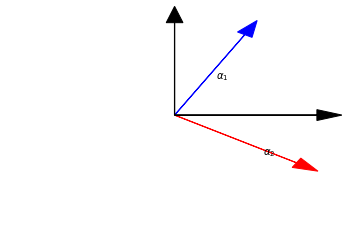

In [ ]:
q = min_result.x
alphax1, alphay1, offset1 = q[:3]
alphax2, alphay2, offset2 = q[3:]

s1 = alphax1**2 + alphay1**2
s2 = alphax2**2 + alphay2**2

if (s2 > s1):
  alphax1, alphay1, offset1 = q[3:]
  alphax2, alphay2, offset2 = q[:3]
  temp = s1
  s1 = s2
  s2 = temp

alphax1 /= s1**0.5 * 2
alphay1 /= s1**0.5 * 2
alphax2 /= s2**0.5 * 2
alphay2 /= s2**0.5 * 2

fig, ax = plt.subplots(1, 1)

ax.arrow(0.5, 0.5, alphax1, alphay1, color='b', head_width=0.05, length_includes_head=True)
plt.annotate(r"$\alpha _1 $", (alphax1/2+0.5, alphay1/2+0.45))

ax.arrow(0.5, 0.5, alphax2, alphay2, color='r', head_width=0.05, length_includes_head=True)
plt.annotate(r"$\alpha_2 $", (alphax2/2+0.55, alphay2/2+0.45))

ax.arrow(0.5, 0.5, 0.5,0, color='k', head_width=0.05, length_includes_head=True)
ax.arrow(0.5, 0.5, 0,0.5, color='k', head_width=0.05, length_includes_head=True)
ax.axis('off')

plt.show()

Di seguito riportiamo invece un plot che confronta il messaggio calcolato dalla rete con quello ricavato come combinazione lineare sulla forza fisica.

L'eventuale linearità della relazione è una ulteriore conferma di quanto ipotizzato sopra.

In [ ]:
fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))

cam = Camera(fig)

for t in tqdm(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[t])

  msgs['bd'] = msgs.r + 1e-2                #10-2 per evitare che r = 0 a denominatore dopo

  msg_columns = ['e%d'%(k) for k in range(par.msg_dim)]
  msg_array = np.array(msgs[msg_columns])

  msg_importance = msg_array.std(axis=0)
  most_important = np.argsort(msg_importance)[-dim:]            # sto prendendo le dim componenti più importanti
  msgs_to_compare = msg_array[:, most_important]
  msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

  min_result = minimize(linear_transformation, np.ones(dim**2 + dim), method='Powell')

  for i in range(dim):
    if dim == 3:
        px = out_linear_transformation_3d(min_result.x)[i]
    else:
        px = out_linear_transformation_2d(min_result.x)[i]

    py = msgs_to_compare[:, i]
    ax[i].scatter(px, py,
                  alpha=0.1, s=0.1, color='k')
    ax[i].set_xlabel('Messaggio come combinazione lineare di forze')
    ax[i].set_ylabel('Elemento di messaggio rilevante %d'%(i+1))

    xlim = np.array([np.percentile(px, q) for q in [10, 90]])
    ylim = np.array([np.percentile(py, q) for q in [10, 90]])
    xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
    ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
  plt.tight_layout()

  cam.snap()
plt.close()
ani = cam.animate()
HTML(ani.to_jshtml())

100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


# Predizione delle traiettorie

Proviamo a ricostruire le traiettorie delle particelle integrando il moto con l'accelerazione ottenuta dal modello e confrontandolo con le traiettorie simulate.

In [ ]:
from scipy.integrate import odeint
from simulate import make_transparent_color

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in range(0,len(recorded_models),int(len(recorded_models)/3)):
    i = 4 #Con questa i stiamo selezionando la simulazione reale 
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        #qui stiamo prendendo i pesi della i-esima epoch
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # la prima simulazione che stampa è una simulazione in cui il modello è inizializzato con pesi randomici, quindi l'acc è a media 0
        ogn = OGN(par.n_f, par.msg_dim, par.out_dim, dt=0.1, hidden=par.hidden_dim, edge_index=get_edge_index(par.nodes, sim), aggr=par.aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(4, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )

        dx = y[:, 2:4] #le y erano le accelerazioni (dx è la soluzione esatta)
        #print(dx.shape)
        dv = ogn.just_derivative(cur).cpu().detach().numpy() #
        #print(dv.shape)
        dother = np.zeros_like(dx)
        #print(dother.shape)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 4, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], s=1, color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], s=1, color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], s=1, color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()


plt.close()
# camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

#Regressione Simbolica

Dopo aver allenato la nostra rete sui dati e analizzato il risultato, sfruttiamo le considerazioni fisiche fatte sul messaggio più significativo per ottenere una forma esplicità dell'interazione tra due nodi. Per farlo utilizziamo il metodo di regressione simbolica all'interno del pacchetto PySR. 
PySR è stato scritto in ambiente Julia, per questo motivo iniziamo scaricando i pacchetti di Julia e PySR. 

##Installazione pacchetti PySR e Julia 

In [ ]:
%pip install -Uq pysr

In [ ]:
%%capture
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.3"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

In [ ]:
%%capture
from julia import Julia

julia = Julia(compiled_modules=False)
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

import pysr
from pysr import PySRRegressor
pysr.install()


## Parentesi sui modelli di regressioni simbolica

La regressione simbolica è una generalizzazione dei metodi di regressione lineare o polinomiale in cui invece di cercare nello spazio di parametri di una funzione definita cerchiamo nello spazio di tutte le possibili formule matematiche, partendo da un set definito di operatori. Componendo funzioni e operazioni dall'insieme dato al modello, questo ritorna quella che meglio approssima i dati, facendo un compromesso tra complicatezza e livello di approssimazione della funzione. 

Lo spazio delle funzioni matematiche è strutturalmente discreto mentre lo spazio dei parametri è continuo. Lo spazio delle funzioni cresce esponenzialmente con la lunghezza dell'espressione, per questo motivo per la ricerca della migliore funzione vengono utilizzati algoritmi di machine learning. 

La regressione simbolica combina algoritmi genetici, simulated annealing e il gradient-free optimization per trovare l'equazione che meglio descriva i dati. 

Negli algoritmi genetici viene creata una popolazione random di individui (in questo caso di funzioni) ai quali viene assegnato uno score o fitness in funzione della loro capacità di risolvere un certo task (nel nostro caso rappresentare il dataset). I migliori individui vengono poi combinati tra loro o mutati casualmente per essere utilizzati in una iterazione successiva dell'algoritmo. 

Nel genetic programming gli individui sono degli alberi binari, nell'immagine sottostante si possono vedere degli esempio di funzione scritti ad albero. 

In [ ]:
#@title Esempio di funzioni scritte ad albero { vertical-output: true, display-mode: "form" }
from IPython.display import Image
Image(url='https://drive.google.com/uc?export=view&id=1V6Sd1BRpTGJzn-TzSk2CNWjxZllIUcCI', width=700)

Un esempio di mutazione di un albero può essere: 

*   Selezionare un nodo dell'albero in modo casuale; 
*   Sostituirle il ramo di albero identifcato da quel nodo con un subtree differente. 

Esistono poi altri metodi tra cui quello di scambiare pezzi tra alberi con score elevato. 



In [ ]:
#@title Mutazione { run: "auto", display-mode: "form" }
Image(url='https://drive.google.com/uc?export=view&id=16l_xRRfYgn1mAhUfQi9L3VKNAYSHi3SV', width=700)

In particolare il modello PySR è un algoritmo di Regularized Evolution o Aging Evolution: 
viene creata una popolazione di P individui inizialmente scelti random che poi viene aggiornata ad ogni ciclo. Un ciclo corrisponde alle seguenti operazioni: 


*   vengono scelti S alberi tra i P in modo randomico, il migliore tra questi viene chiamato genitore; 
*   dal genitore viene costruito tramite mutazione un albero detto figlio;
*   il figlio viene reinserito nella popolazione sostituendo l'elemento più vecchio. 

Sostituire con il più vecchio invece che con il meno performante (non-aging evolution) permette di non focalizzarsi troppo presto su strutture poco accurate e di osservare uno spazio delle variabili più ampio.


Il Simulated Annealing si combina con gli algoritmi genetici per velocizzare la ricerca del minimo. Nel caso in cui il figlio abbia una Loss maggiore dell'elemento più vecchio la sostituzione avviene con probabilità: 



$$e^{\frac{L_{child} - L_{old}}{T}}$$

dove T è un parametro chiamato temperatura che diminuisce andando avanti nel ciclo. 








##Definizione e applicazione del modello PySR

Definiamo il modello da utilizzare assegnando gli operatori in cui cercare ed il numero di iterazioni da ripetere nel tentativo di cercare la migliore funzione. 

Abbiamo assegnato il minimo numero di operatori da utilizzare specifici per il tipo di interazione che stavamo cercando. Questo ci ha permesso di avere una maggiore efficienza sullo specifico problema.

In [ ]:
pysr_model = PySRRegressor(
    model_selection = 'best',
    niterations= par.pysr_iterations,
    binary_operators=["plus", "mult", "div", "sub"],
    unary_operators=["square", "cube"],
)

Il messaggio a cui corrisponde la miglior validation loss è salvato in 'best_message':

In [ ]:
best_message = np.argmax([np.std(messages_over_time[int(best_index/frac)]['e%d'%(i,)]) for i in range(par.msg_dim)])

In [ ]:
messages_over_time[int(best_index/frac)][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

e0        dx        dy         r        m1        m2
0     -0.525798 -0.338722 -0.608699  0.696596  0.247505  0.790183
1     -0.228193 -0.782398 -0.073313  0.785826  0.247505  1.275501
2     -1.485456  1.778154  0.957582  2.019602  0.247505  1.919946
3      0.454252  0.338722  0.608699  0.696596  0.790183  0.247505
4      0.143750 -0.443677  0.535385  0.695332  0.790183  1.275501
...         ...       ...       ...       ...       ...       ...
11995  0.061051  0.646771 -0.216961  0.682191  1.373034  1.440178
11996 -0.287301  0.364905 -0.484841  0.606816  1.373034  0.152508
11997 -0.106108  0.850960  0.594375  1.037986  0.152508  0.522687
11998  0.919880  0.281867  0.267880  0.388855  0.152508  1.440178
11999  0.219262 -0.364905  0.484841  0.606816  0.152508  1.373034

[12000 rows x 6 columns]

Applichiamo il modello:

In [ ]:
X = messages_over_time[int(best_index/frac)][['dx', 'dy', 'r', 'm1', 'm2']] #parametri del fit 
Y = messages_over_time[int(best_index/frac)][['e%d'%(best_message,)]] #valori che voglio approssimare con la funzione

pysr_model.fit(X= X, y=Y)

/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1069: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "
/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1564: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/#/options?id=batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  "Note: you are running with more than 10,000 datapoints. "


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.035022244   
	1         0.412077                                   (dy * -0.668542)   
	2         0.170361                          ((dy + dx) * -0.52492505)   
	3         0.385271                    (((dy * r) + dx) * -0.32221088)   
	4         0.331085        (((1.1147562 / r) - 1.1260266) * (dy + dx))   
	5   >>>>  1.753711  (((1.4242781 / r) - 1.4387258) * (dy + (dx * 0...   
	6         0.348920  ((((1.4242789 / r) - 1.438726) * (dy + (dx * 0...   
	7         0.000024  ((((1.4242675 / r) - 1.438719) * ((dy + (dx * ...   
	8         0.001654  ((((1.4242772 / r) - 1.4387257) * ((dy + (dx *...   
	9         0.034193  ((((1.4242772 / r) - 1.4387257) * ((dy + (dx *...   
	10        0.613090  ((((1.424278 / r) - 1.4387261) * ((dy + (dx * ...   
	
	        loss  complexity  
	0   1.090469           1  
	1   0.478286           3

Stampiamo il risultato del modello e la best function

In [ ]:
print(pysr_model) 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.035022244   
	1         0.412077                                   (dy * -0.668542)   
	2         0.170361                          ((dy + dx) * -0.52492505)   
	3         0.385271                    (((dy * r) + dx) * -0.32221088)   
	4         0.331085        (((1.1147562 / r) - 1.1260266) * (dy + dx))   
	5   >>>>  1.753711  (((1.4242781 / r) - 1.4387258) * (dy + (dx * 0...   
	6         0.348920  ((((1.4242789 / r) - 1.438726) * (dy + (dx * 0...   
	7         0.000024  ((((1.4242675 / r) - 1.438719) * ((dy + (dx * ...   
	8         0.001654  ((((1.4242772 / r) - 1.4387257) * ((dy + (dx *...   
	9         0.034193  ((((1.4242772 / r) - 1.4387257) * ((dy + (dx *...   
	10        0.613090  ((((1.424278 / r) - 1.4387261) * ((dy + (dx * ...   
	
	        loss  complexity  
	0   1.090469           1  
	1   0.478286           3

In [ ]:
print('Funzione con il miglior score:\n')
pysr_model.sympy()

Funzione con il miglior score:



(-1.4387258 + 1.4242781/r)*(0.565707*dx + dy)

## Considerazioni sulla scelta della funzione migliore

Bisogna fare attenzione all'overfittinig, ovvero a costruire funzioni sempre più complesse con un numero di nodi molto alto e che sovrarappresentino i dati. 

Per questo motivo lo score o fitness che viene assegnato ad ogni albero/funzione è un compromesso tra capacità di rappresentazione dei dati e complessità. 

In particolare la funzione che assegna lo score è: 

$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$

dove la funzione loss é il MSE sui dati. Identifico la funzione migliore come quella per cui ho un drop relativo in loss più alto (a parità di complessità), cioè cerco la funzione capace di cogliere più caratteristiche dei miei dati. 

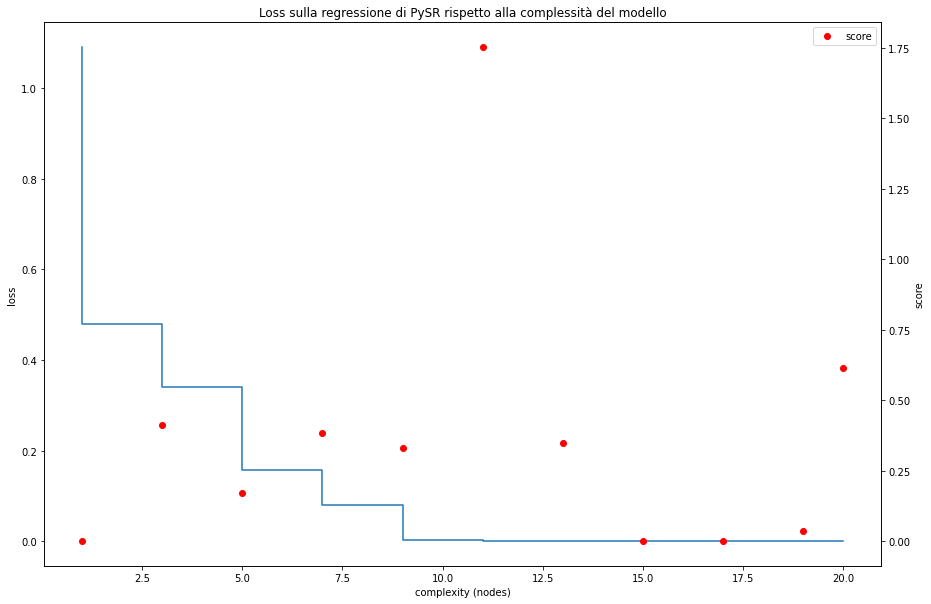

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
loss = pysr_model.equations_.loss
complexity =  pysr_model.equations_.complexity
score = pysr_model.equations_.score
max_score = max(score)
ax.step(complexity, loss)
ax.set_ylabel('loss')
ax1 = ax.twinx() 

x = list(range(1,14))
ax1.plot(complexity, score, 'ro', label= 'score')
ax1.set_ylabel('score')
ax.set_title('Loss sulla regressione di PySR rispetto alla complessità del modello')
ax.set_xlabel('complexity (nodes)')
plt.legend()